In [1]:
%matplotlib inline


## Import libraries

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.linear_model import Lasso, LinearRegression, LassoCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold

# pip install mlxtend
from mlxtend.plotting import plot_decision_regions

## Linear models

### Load data

In [3]:
diabetes = datasets.load_diabetes()
X = diabetes.data[:150]
y = diabetes.target[:150]

print(X.shape, y.shape)

(150, 10) (150,)


### Settings

In [4]:
# Metric: Mean Absolute Error
scoring= 'neg_mean_absolute_error'

# CV: 3-fold
kf = KFold(3)

# Create linear regressor
linreg = LinearRegression()

# Create lasso regressor
lasso = Lasso(alpha=0.5, random_state=0, max_iter=10000)

# Try different lambdas (regularization )
lambdas = np.logspace(-4, -0.5, 30)

print('Number of lambdas: {0} [{1:.4}, {2:.4}]'.format(lambdas.size, lambdas.min(), lambdas.max()))

Number of lambdas: 30 [0.0001, 0.3162]


### Learning

In [5]:
# Fit Linear regression
linreg_scores_cv = cross_val_score(linreg, X, y, scoring=scoring, cv=kf)
linreg_score = -linreg_scores_cv.mean()

# Fit Lasso
clf = GridSearchCV(lasso, {'alpha': lambdas}, cv=kf, refit=True, scoring=scoring, iid=False).fit(X, y)
lasso_scores = -clf.cv_results_['mean_test_score']

### Plot scores

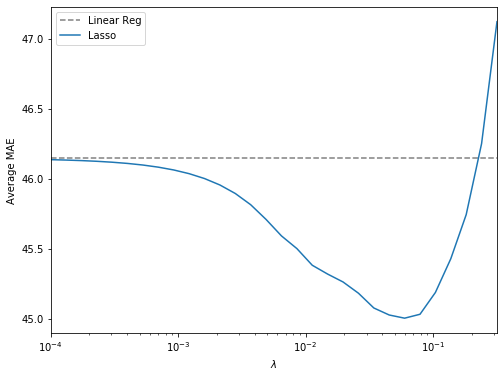

In [6]:
plt.figure().set_size_inches(8, 6)

# Plot LR
plt.axhline(linreg_score, linestyle='--', color='.5')

# Plot Lasso
plt.semilogx(lambdas, lasso_scores)

plt.xlim([lambdas[0], lambdas[-1]])
plt.ylabel('Average MAE')
plt.xlabel('$\lambda$')
plt.legend(['Linear Reg', 'Lasso'], loc='upper left')
plt.show()

In [7]:
print('Best lambda: {0:.3}'.format(lambdas[np.argmin(lasso_scores)]))

Best lambda: 0.0597


In [8]:
coefs = clf.best_estimator_.coef_
print('Selected features: {0}/{1}'.format(np.count_nonzero(coefs), coefs.size))

Selected features: 8/10


In [9]:
print('What about generalization? How good is this lambda?')

What about generalization? How good is this lambda?


## Nested vs non-nested CV

### Lasso with inner CV for lambda selection (Train-Validation splits)

In [10]:
inner_kf = KFold(3)
clf = LassoCV(alphas=lambdas, cv=inner_kf, random_state=0, max_iter=10000)

### Outer CV (Test data)

In [11]:
outter_kf = KFold(5)
for k, (train, test) in enumerate(outter_kf.split(X, y)):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    
    print('[fold {0}] best lambda: {1:.5f}  --  MAE on test: {2:.5f}'. format(k, clf.alpha_, mae))

[fold 0] best lambda: 0.10405  --  MAE on test: 40.51337
[fold 1] best lambda: 0.05968  --  MAE on test: 52.21112
[fold 2] best lambda: 0.10405  --  MAE on test: 39.08356
[fold 3] best lambda: 0.10405  --  MAE on test: 52.33008
[fold 4] best lambda: 0.18139  --  MAE on test: 45.27109


## Linear vs Non-linear SVM

### Create XOR data

In [12]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(100, 2)
y = np.array(np.logical_xor(X[:, 0] > 0, X[:, 1] > 0), dtype=int)

print(X.shape, y.shape)

(100, 2) (100,)


### Stratified split: 70% train, 30% test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, random_state=23, stratify=y)

print(X_train.shape, X_test.shape)

(70, 2) (30, 2)


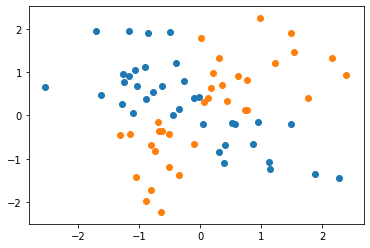

In [14]:
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1])
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1])

### Create SVM classifiers and fit to train

In [15]:
clfs = {'Linear': SVC(kernel='linear', gamma='scale'), 
        'Poly[2]': SVC(kernel='poly', degree=2, gamma='scale'),
        'Sigmoid': SVC(kernel='sigmoid', gamma='scale'),
        'RBF': SVC(kernel='rbf', gamma='scale')}

# Fit to train
for i, (kernel, clf) in enumerate(clfs.items()):
    clf.fit(X_train, y_train)

### Plot boundaries

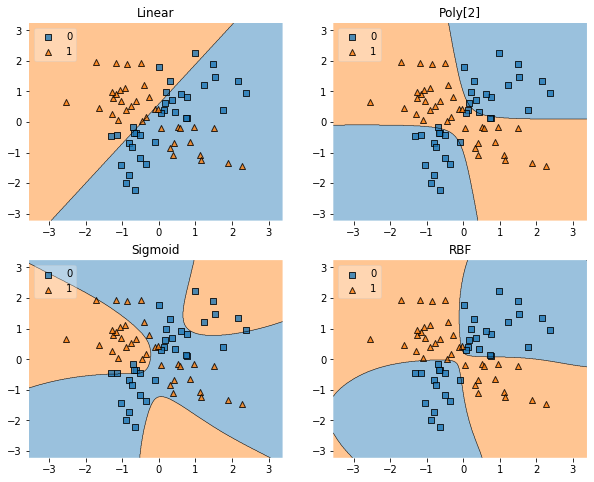

In [16]:
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))
for i, (kernel, clf) in enumerate(clfs.items()):
    ax = plt.subplot(gs[i//2, i%2])
    fig = plot_decision_regions(X=X_train, y=y_train, clf=clf, legend=2)
    plt.title(kernel)
plt.show()

### Evaluate models on hold-out data

In [17]:
for i, (kernel, clf) in enumerate(clfs.items()):
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('SVM {0:<7}: {1:.3f}'.format(kernel, acc))
    

SVM Linear : 0.633
SVM Poly[2]: 0.867
SVM Sigmoid: 0.567
SVM RBF    : 0.967
